In [1]:
import torch
import torchvision

In [2]:

batch_size_train = 32
batch_size_test = 32
learning_rate = 0.01
momentum = 0.5

random_seed = 1
#torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Colored MNIST

In [16]:
import random
def coloring_frame(img):
    clrs = [torch.tensor([1, 0, 0], dtype=torch.float),
                  torch.tensor([0, 1, 0], dtype=torch.float), torch.tensor([0, 0, 1], dtype=torch.float)]
    img = img.to(device).expand([3, -1, -1]).transpose(0, 2)
    dclr_idx, bclr_idx = random.sample(list(range(len(clrs))), 2)
    dclr, bclr = clrs[dclr_idx], clrs[bclr_idx]
    img_digit = img * dclr.to(device)
    img_background = (1-img) * bclr.to(device)
    img_background[3:-3, 3:-3, :] = 0
    return (img_digit+img_background).transpose(0, 2), dclr_idx, bclr_idx

In [17]:
class ColMNIST(torchvision.datasets.MNIST):
    def __init__(
            self,
            root,
            train = True,
            transform = None,
            target_transform = None,
            download = True, only_frame = True):
        super(ColMNIST, self).__init__(root, train=train, transform=transform,
                                    target_transform=target_transform, download=download)
        if only_frame:
            self.col_f = coloring_frame
        else:
            self.col_f = coloring

    def __getitem__(self, index):
        img, target = super(ColMNIST, self).__getitem__(index)
        img, dclr_idx, bclr_idx = self.col_f(img)
        return img, (torch.tensor(target ,device=device),
                     torch.tensor(dclr_idx, dtype=torch.long, device=device),
                     torch.tensor(bclr_idx, dtype=torch.long, device=device))

# Loading the data

In [18]:
train_loader = torch.utils.data.DataLoader(
  ColMNIST('data/mnist', train=True, download=True,
                             transform=torchvision.transforms.Compose([#torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  ColMNIST('data/mnist', train=False, download=True,
                             transform=torchvision.transforms.Compose([#torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [19]:
cm = ColMNIST('data/mnist', train=True, download=True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                             ]))
cm[13]

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'),
 (tensor(6, device='cuda:0'),
  tensor(1, device='cuda:0'),
  tensor(0, device='cuda:0')))

In [20]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([32, 3, 28, 28])

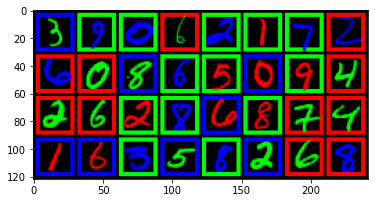

torch.Size([3, 28, 28])

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
images[0].shape
#print(labels)

# VGG

In [63]:


# Imports
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.nn.functional as F
import torch.optim as optim
VGG_types = {
    "VGG11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG13": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG16": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        "M",
    ],
    "VGG19": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        512,
        "M",
    ],
}


class VGG_net(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super(VGG_net, self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layers(VGG_types["VGG16"])

        self.fcs = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
        )
        self.fcs_last = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fcs(x)
        self.features = self.fcs_last(x)
        return F.log_softmax(x)

    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x

                layers += [
                    nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=(3, 3),
                        stride=(1, 1),
                        padding=(1, 1),
                    ),
                    nn.BatchNorm2d(x),
                    nn.ReLU(),
                ]
                in_channels = x
            elif x == "M":
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

        return nn.Sequential(*layers)

In [64]:
network = VGG_net(in_channels=3, num_classes=(10)).to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

# Small ConvNet

In [65]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [66]:
class Net(nn.Module):
    def __init__(self, in_channels=3):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2_1 = nn.Linear(50, 10)
        self.fc2_2 = nn.Linear(50, 3)
        self.fc2_3 = nn.Linear(50, 3)
        self.original_w = None

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        self.features = F.relu(self.fc1(x))
        x = F.dropout(self.features, training=self.training)
        x1 = self.fc2_1(x)
        x2 = self.fc2_2(x)
        x3 = self.fc2_3(x)
        return (F.log_softmax(x1), F.log_softmax(x2), F.log_softmax(x3)) #
    

In [155]:
network = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

# Training

In [156]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

log_interval = 100

In [164]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output  = network(data.to(device))
        loss = 0
        for t in range(len(target)):
            target[t] = target[t].to(device)
            loss += F.nll_loss(output[t], target[t])
        #l0.3 regularization
        l = torch.tensor(0.001).to(device)
        reg = torch.tensor(0.).to(device)
        for param in network.parameters():
            reg += torch.norm(param, p=0.9)
        loss += l * reg    
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)] \tLoss: {}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), 'model.pth')
            torch.save(optimizer.state_dict(), 'optimizer.pth')

In [165]:
def test():
    network.eval()
    test_loss = [0, 0, 0]
    correct = [0, 0, 0]
    ll_activations = []
    pred_lst = []
    with torch.no_grad():
        for data, target in test_loader:
            output  = network(data.to(device))
            for t in range(len(target)):
                target[t] = target[t].to(device)
                test_loss[t] += F.nll_loss(output[t], target[t], size_average=False).item()
                pred = output[t].data.max(1, keepdim=True)[1]
                correct[t] += pred.eq(target[t].data.view_as(pred)).sum()
            pred_lst.append(torch.cat([o.data for o in output], dim=1))
            ll_activations.append(network.features)
    test_loss = [tl/len(test_loader.dataset) for tl in test_loss]
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {}, Correct: {}/{}, Accuracy: {}\n'.format(
    test_loss, correct, len(test_loader.dataset),
    [100. * c.item() / len(test_loader.dataset) for c in correct]))
    return torch.cat(ll_activations), torch.cat(pred_lst)

In [166]:
import numpy as np

n_epochs = 3
merged = []
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    ll_act, pred = test()
    
    merged = np.hstack((ll_act, pred))

/home/c01ekar/anaconda3/envs/diseNN/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: [2.304543956375122, 1.1010964023590089, 1.0990267893473307], Correct: [tensor(6718, device='cuda:0'), tensor(19478, device='cuda:0'), tensor(17518, device='cuda:0')]/60000, Accuracy: [11.196666666666667, 32.46333333333333, 29.196666666666665]

Train Epoch: 1 [0/60000 (0%)] 	Loss: 6.405602931976318
Train Epoch: 1 [3200/60000 (5%)] 	Loss: 5.532715320587158
Train Epoch: 1 [6400/60000 (11%)] 	Loss: 4.53177547454834
Train Epoch: 1 [9600/60000 (16%)] 	Loss: 3.8435401916503906
Train Epoch: 1 [12800/60000 (21%)] 	Loss: 3.4397218227386475
Train Epoch: 1 [16000/60000 (27%)] 	Loss: 3.3739993572235107
Train Epoch: 1 [19200/60000 (32%)] 	Loss: 3.2213170528411865
Train Epoch: 1 [22400/60000 (37%)] 	Loss: 3.011392593383789
Train Epoch: 1 [25600/60000 (43%)] 	Loss: 3.109894275665283
Train Epoch: 1 [28800/60000 (48%)] 	Loss: 2.9430716037750244
Train Epoch: 1 [32000/60000 (53%)] 	Loss: 2.9562578201293945
Train Epoch: 1 [35200/60000 (59%)] 	Loss: 2.8806803226470947
Train Epoch: 1 [3

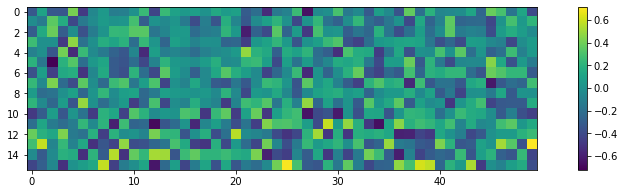

In [105]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,3))
corrm = np.corrcoef(np.transpose(merged))[-16:, :-16]
plt.imshow(corrm)
plt.colorbar()

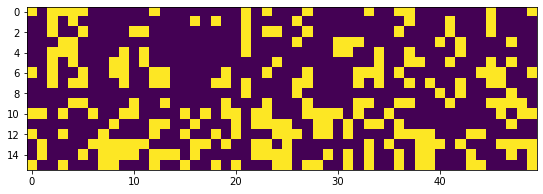

In [106]:
corr_thr = 0.3
plt.figure(figsize=(15,3))
plt.imshow(np.abs(corrm)>corr_thr)

# Finding connected components

In [121]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
corr_thr = 0.6
corrm_full = np.corrcoef(np.transpose(merged))
graph = csr_matrix(np.abs(corrm_full)>corr_thr)

n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)
n_components, labels[:50], labels[50:60], labels[60:63], labels[63:66]

(36,
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 12,
         6, 15, 10, 16, 17, 18,  0, 12, 12, 19,  0, 20, 21,  0, 22, 23, 12,
        12, 24, 12, 25, 12, 26,  1, 27, 28, 29, 15,  0, 30, 27,  6,  0],
       dtype=int32),
 array([ 0, 31, 17, 32, 33,  2,  0,  0, 34,  0], dtype=int32),
 array([ 0, 12, 35], dtype=int32),
 array([ 0, 12, 12], dtype=int32))

In [154]:
# Last layer graph
w1 = network.fc2_1.weight.cpu().detach().numpy()
w2 = network.fc2_2.weight.cpu().detach().numpy()
w3 = network.fc2_3.weight.cpu().detach().numpy()
w = np.vstack([w1, w2, w3])
graph = np.block([
                 [np.zeros((w.shape[0], w.shape[0])), w],
                 [w.transpose(),                      np.zeros((w.shape[1], w.shape[1]))]])


graph = csr_matrix(np.abs(graph)>0.45)

n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)
n_components, labels[:3], labels[3:6], labels[6:16], labels[16:66]

(21,
 array([0, 1, 2], dtype=int32),
 array([3, 0, 4], dtype=int32),
 array([0, 5, 6, 7, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([ 0,  0,  8,  9, 10, 11,  0,  0,  0,  0, 12, 13,  0,  0,  0,  0,  1,
         0,  0, 14,  0, 15,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0, 16,  0,
         0,  0,  0,  0,  0,  0,  0, 17, 18,  0,  0, 19,  0, 20,  0,  0],
       dtype=int32))

# Autoencoder

In [167]:
class AE(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=input_shape, out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=input_shape
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

In [170]:
input_shape = (3, 28, 28)
flat
ae = AE(flat_shape)

for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        batch_features = batch_features.view(-1, 784).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

# Masking

In [107]:
w_thr = 0.03
plt.figure(figsize=(15,3))
plt.imshow((np.abs(corrm)>corr_thr) * (network.fc2_1.weight>w_thr))

ValueError: operands could not be broadcast together with shapes (16,50) (10,50) 

<Figure size 1080x216 with 0 Axes>

In [ ]:
#network.mask = torch.tensor((np.abs(corrm)>corr_thr).astype(float)).float()
for c in range(1, 10):
    network.set_mask(torch.tensor((np.abs(corrm)>c/10).astype(float)).float())
    print(c)
    test()

In [ ]:
network.set_mask(torch.ones(10, 50))
w = network.fc2.weight
for c in range(1, 20):
    network.set_mask(torch.tensor((w>c/100)).float())
    print(c/100)
    test()

In [ ]:
act = [[] for i in range(10)]
for num, neu in zip(*np.where(network.mask > 0)):
    act[num].append(neu)
s = list(set([item for sublist in act for item in sublist]))
mapping = {a: i for i, a in enumerate(s)}
act_remapped = [[mapping[i] for i in sublist] for sublist in act]
act_remapped

In [ ]:
network.set_mask(torch.ones(10, 50))
w = network.fc2.weight
corr_thr = 0.3
w_thr = 0.03
print("Connections with corr >{} : {}%".format(corr_thr, len(np.where(np.abs(corrm)>corr_thr)[0])/500*100))
print("Connections with corr >{} and w > {}: {}%".format(corr_thr, w_thr, len(np.where((np.abs(corrm)>corr_thr) * (w >w_thr))[0])/500*100))
print("Connections with corr >{} or w > {}: {}%".format(corr_thr, w_thr, len(np.where((np.abs(corrm)>corr_thr) + (w >w_thr))[0])/500*100))

In [ ]:
network.set_mask(torch.tensor((np.abs(corrm)>0.2).astype(float)*(w>0.03)).float())
test()

In [ ]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
network.set_mask(torch.tensor((np.abs(corrm)>0.2).astype(float)*(w>0.03)).float())

In [ ]:
plt.figure(figsize=(15,3))
plt.imshow(network.mask)
print(len(torch.nonzero(network.mask)))

In [ ]:
merged = []
test()
print(len(torch.nonzero(network.mask)))
for epoch in range(1, n_epochs + 1):
    train(epoch)
    print(len(torch.nonzero(network.mask)))
    ll_act, pred = test()
    print(ll_act.shape, pred.shape)
    merged = np.hstack((ll_act, pred))

In [ ]:
plt.figure(figsize=(15,3))
plt.imshow(network.mask)
plt.colorbar()
test()

In [ ]:
l = []
for p in network.parameters():
    l.append(p.data.flatten())
l = torch.cat(l)

In [ ]:
plt.hist(l, bins=500, range=(-1, 1))

In [ ]:
subgroups = [[0, 5],
             [1, 6],
             [4, 7],
             [3, 4, 8],
             [9],
             [3, 10],
             [2, 11],
             [1, 12],
             [0, 2, 13],
             [0, 14]
             ]
sg_size = 3
mask = torch.zeros(10, 50)
for i, s in enumerate(subgroups):
    #self.subgroups.append([x*sg_size+i for x in s for i in range(sg_size)])
    for x in s:
        mask[i, x*sg_size:x*sg_size+sg_size]=1
    
plt.figure(figsize=(15,3))
plt.imshow(mask)
plt.colorbar()

In [ ]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
network.set_mask(torch.tensor(mask).float())
merged = []
test()
print(len(torch.nonzero(network.mask)))
for epoch in range(1, n_epochs + 1):
    train(epoch)
    print(len(torch.nonzero(network.mask)))
    ll_act, pred = test()
    print(ll_act.shape, pred.shape)
    merged = np.hstack((ll_act, pred))

In [ ]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
network.set_mask(torch.zeros(10, 50).float())
merged = []
test()
print(len(torch.nonzero(network.mask)))
for epoch in range(1, n_epochs + 1):
    train(epoch)
    print(len(torch.nonzero(network.mask)))
    ll_act, pred = test()
    print(ll_act.shape, pred.shape)
    merged = np.hstack((ll_act, pred))

In [ ]:
import numpy as np

plt.figure(figsize=(15,15))
plt.imshow(np.corrcoef(np.transpose(merged)))
